<a href="https://colab.research.google.com/github/NikosKats/ColabFiles/blob/TrainingAClassifier_CIFAR-10/TrainingAClassifier_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import matplotlib.pyplot as plt
import numpy as np



In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [3]:
batch_size=8

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [7]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [9]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

In [10]:
dataiter = iter(trainloader)

In [11]:
images,labels = next(dataiter)

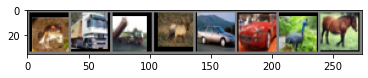

In [12]:
imshow(torchvision.utils.make_grid(images))

In [13]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

frog  truck truck deer  car   car   bird  horse


In [14]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [16]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss +=loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.191
[1,  4000] loss: 1.896
[1,  6000] loss: 1.748
[2,  2000] loss: 1.648
[2,  4000] loss: 1.560
[2,  6000] loss: 1.537
Finished Training


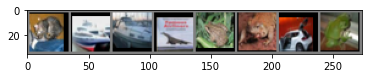

GroundTruth:  cat   ship  ship  plane
Predicted:  plane plane plane plane
Accuracy of the network on the 10000 test images: 9%


In [17]:
PATH = './cifar_net.path'
torch.save(net.state_dict,PATH)

dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = Net()

torch.save(net.state_dict(), PATH) # nothing else here
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

In [18]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader: 
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    for label, prediction in zip(labels, predicted):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1



In [19]:
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

net.to(device)

inputs,labels = data[0].to(device), data[1].to(device)

del dataiter

Accuracy for class: plane is 96.2 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.5 %
Accuracy for class: truck is 0.0 %
cuda:0
